# Music Genre Classification
An music classifier using multiple machine learning methods

**Neural Networks** • **SVMs** • **Logistic Regression**


---
Authors 
- David Chang
- Denizhan Ene
---
Credits
- Dataset: [GTZAN Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)
- sklearn: [Docs](https://scikit-learn.org/0.21/documentation.html)
---

For local installations:
```Shell
pip install kaggle
kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
```

# Setup

In this section, we set up the dataset by establishing a directory where it is and where the information will be contained in. The CSV is stored in a shared Google Drive directory that could be accessed by mounting the drive.

We utilize many libraries in the project so this is the place we put all the imports as well.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# |‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾|
# |                           |
# |          Imports          |
# |                           |
# |___________________________|

import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
import librosa
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay

Included in the dataset are two csv files, one with 1000 samples that contain 30 seconds of data. The other one has ~ 9990 samples but only with 3 seconds of data.

We're planning running the model on both.

In [ ]:
# |‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾|
# |                           |
# |         null check        |
# |                           |
# |___________________________|

# check if any values need filling

#read feature data from csv file
#hosted in google drive
df_30sec = pd.read_csv("/content/drive/MyDrive/ML_genre_classification_nn_project/Data/features_30_sec.csv")
df_3sec = pd.read_csv("/content/drive/MyDrive/ML_genre_classification_nn_project/Data/features_3_sec.csv")
print(f'shape of the first dataset:{df_30sec.shape}')
print(f'shape of the second dataset:{df_3sec.shape}')
# print(df.head())
# print(df2.head())

# print(df_30sec.isnull())
# print(df_3sec.isnull())
# None

# |‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾|
# |                           |
# |       sanity check        |
# |                           |
# |___________________________|


label_index = dict()
for i, j in enumerate(df_30sec.label.unique()):
  label_index[j] = i

# print(f'dictionary with all labels:{label_index}')


# organize into feature/label
X = df_30sec.drop('filename', axis=1)
y = X.pop('label').to_numpy()


X2 = df_3sec.drop('filename', axis=1)
y2 = X2.pop('label').to_numpy()



# print(X2)
# print(y2)

# encode the labels
y = np.array([label_index[x] for x in y]).reshape((y.shape[0],1))

shape of the first dataset:(1000, 60)
shape of the second dataset:(9990, 60)


In [ ]:
X

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


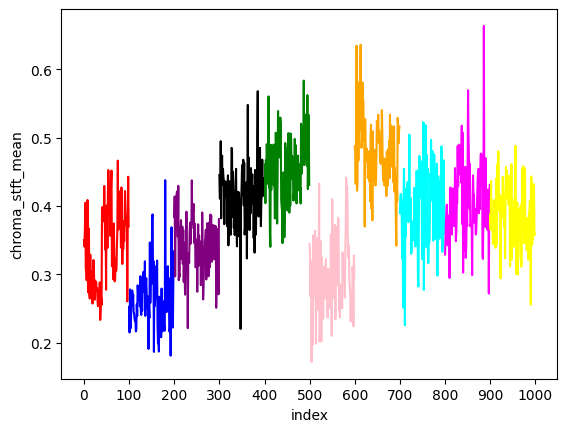

In [ ]:
xticks_positions = np.arange(0, 1001, 100)
xticks_labels = [str(x) for x in xticks_positions]
plt.xticks(np.arange(0, 1001, 100))
plt.ylabel('chroma_stft_mean')
plt.xlabel('index')

plt.plot(range(0,100),X.chroma_stft_mean[0:100], color='red')
plt.plot(range(100,200),X.chroma_stft_mean[100:200], color='blue')
plt.plot(range(200,300),X.chroma_stft_mean[200:300], color='purple')
plt.plot(range(300,400),X.chroma_stft_mean[300:400], color='black')
plt.plot(range(400,500),X.chroma_stft_mean[400:500], color='green')
plt.plot(range(500,600),X.chroma_stft_mean[500:600], color='pink')
plt.plot(range(600,700),X.chroma_stft_mean[600:700], color='orange')
plt.plot(range(700,800),X.chroma_stft_mean[700:800], color='cyan')
plt.plot(range(800,900),X.chroma_stft_mean[800:900], color='magenta')
plt.plot(range(900,1000),X.chroma_stft_mean[900:1000], color='yellow')


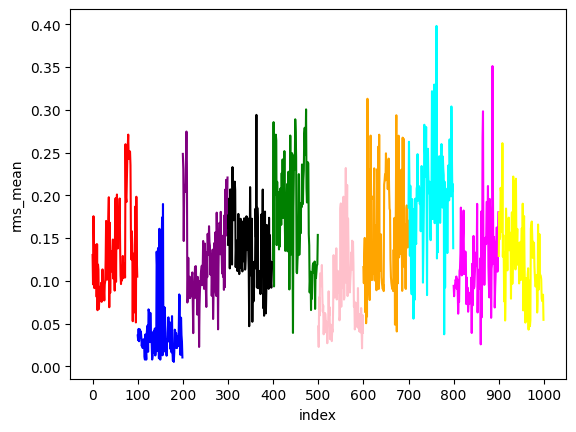

In [ ]:
xticks_positions = np.arange(0, 1001, 100)
xticks_labels = [str(x) for x in xticks_positions]
plt.xticks(np.arange(0, 1001, 100))
plt.ylabel('rms_mean')
plt.xlabel('index')

plt.plot(range(0,100),X.rms_mean[0:100], color='red')
plt.plot(range(100,200),X.rms_mean[100:200], color='blue')
plt.plot(range(200,300),X.rms_mean[200:300], color='purple')
plt.plot(range(300,400),X.rms_mean[300:400], color='black')
plt.plot(range(400,500),X.rms_mean[400:500], color='green')
plt.plot(range(500,600),X.rms_mean[500:600], color='pink')
plt.plot(range(600,700),X.rms_mean[600:700], color='orange')
plt.plot(range(700,800),X.rms_mean[700:800], color='cyan')
plt.plot(range(800,900),X.rms_mean[800:900], color='magenta')
plt.plot(range(900,1000),X.rms_mean[900:1000], color='yellow')

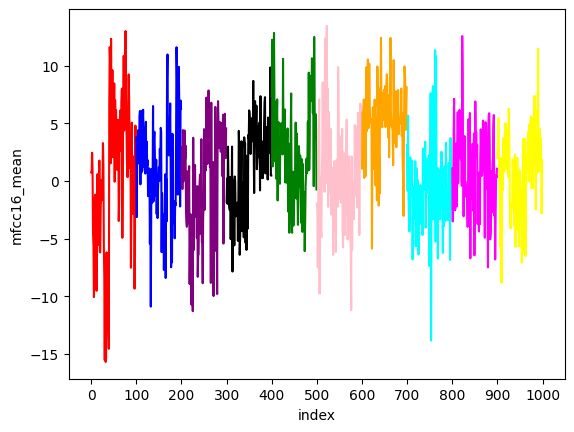

In [ ]:
xticks_positions = np.arange(0, 1001, 100)
xticks_labels = [str(x) for x in xticks_positions]
plt.xticks(np.arange(0, 1001, 100))
plt.ylabel('mfcc16_mean')
plt.xlabel('index')

plt.plot(range(0,100),X.mfcc16_mean[0:100], color='red')
plt.plot(range(100,200),X.mfcc16_mean[100:200], color='blue')
plt.plot(range(200,300),X.mfcc16_mean[200:300], color='purple')
plt.plot(range(300,400),X.mfcc16_mean[300:400], color='black')
plt.plot(range(400,500),X.mfcc16_mean[400:500], color='green')
plt.plot(range(500,600),X.mfcc16_mean[500:600], color='pink')
plt.plot(range(600,700),X.mfcc16_mean[600:700], color='orange')
plt.plot(range(700,800),X.mfcc16_mean[700:800], color='cyan')
plt.plot(range(800,900),X.mfcc16_mean[800:900], color='magenta')
plt.plot(range(900,1000),X.mfcc16_mean[900:1000], color='yellow')

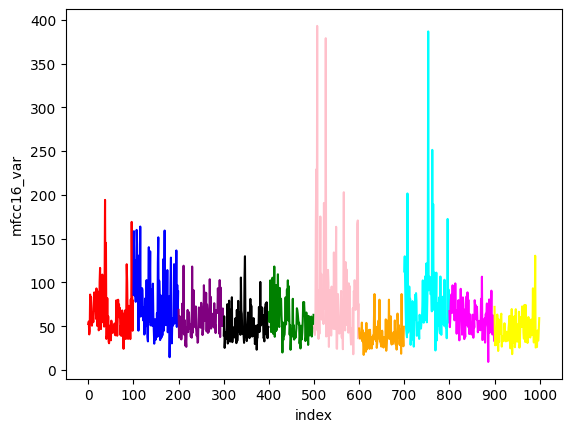

In [ ]:
xticks_positions = np.arange(0, 1001, 100)
xticks_labels = [str(x) for x in xticks_positions]
plt.xticks(np.arange(0, 1001, 100))
plt.ylabel('mfcc16_var')
plt.xlabel('index')

plt.plot(range(0,100),X.mfcc16_var[0:100], color='red')
plt.plot(range(100,200),X.mfcc16_var[100:200], color='blue')
plt.plot(range(200,300),X.mfcc16_var[200:300], color='purple')
plt.plot(range(300,400),X.mfcc16_var[300:400], color='black')
plt.plot(range(400,500),X.mfcc16_var[400:500], color='green')
plt.plot(range(500,600),X.mfcc16_var[500:600], color='pink')
plt.plot(range(600,700),X.mfcc16_var[600:700], color='orange')
plt.plot(range(700,800),X.mfcc16_var[700:800], color='cyan')
plt.plot(range(800,900),X.mfcc16_var[800:900], color='magenta')
plt.plot(range(900,1000),X.mfcc16_var[900:1000], color='yellow')

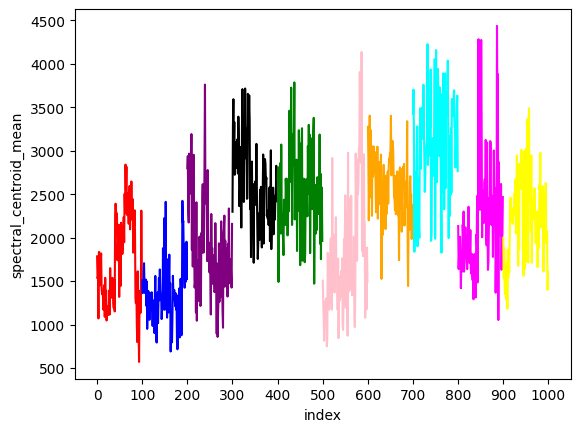

In [ ]:
xticks_positions = np.arange(0, 1001, 100)
xticks_labels = [str(x) for x in xticks_positions]
plt.xticks(np.arange(0, 1001, 100))
plt.ylabel('spectral_centroid_mean')
plt.xlabel('index')

plt.plot(range(0,100),X.spectral_centroid_mean[0:100], color='red')
plt.plot(range(100,200),X.spectral_centroid_mean[100:200], color='blue')
plt.plot(range(200,300),X.spectral_centroid_mean[200:300], color='purple')
plt.plot(range(300,400),X.spectral_centroid_mean[300:400], color='black')
plt.plot(range(400,500),X.spectral_centroid_mean[400:500], color='green')
plt.plot(range(500,600),X.spectral_centroid_mean[500:600], color='pink')
plt.plot(range(600,700),X.spectral_centroid_mean[600:700], color='orange')
plt.plot(range(700,800),X.spectral_centroid_mean[700:800], color='cyan')
plt.plot(range(800,900),X.spectral_centroid_mean[800:900], color='magenta')
plt.plot(range(900,1000),X.spectral_centroid_mean[900:1000], color='yellow')

---


Scale Data

In [ ]:
# |‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾|
# |                           |
# |           TODO!           |
# |                           |
# |___________________________|
# implement normalization?
scalar = preprocessing.StandardScaler()
X = scalar.fit_transform(X)

scalar2 = preprocessing.StandardScaler()
X2 = scalar2.fit_transform(X2)




# split the 30 second data as: 80% training, 20% testing
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X, y, test_size=.2, random_state=42)

#split the 3 second data as: 80% training, 20% testing
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X2, y2, test_size=.2, random_state=42)

print(f'30 seconds training examples shape:\t{X_train_30.shape}')
print(f'30 seconds testing examples shape:\t{X_test_30.shape}')
print(f'30 seconds training labels shape:\t{y_train_30.shape}')
print(f'30 seconds testing labels shape:\t{y_test_30.shape}')
print()

print(f'3 seconds training examples shape:\t{X_train_3.shape}')
print(f'3 seconds testing examples shape:\t{X_test_3.shape}')
print(f'3 seconds training labels shape:\t{y_train_3.shape}')
print(f'3 seconds testing labels shape:\t\t{y_test_3.shape}')



30 seconds training examples shape:	(800, 58)
30 seconds testing examples shape:	(200, 58)
30 seconds training labels shape:	(800, 1)
30 seconds testing labels shape:	(200, 1)

3 seconds training examples shape:	(7992, 58)
3 seconds testing examples shape:	(1998, 58)
3 seconds training labels shape:	(7992,)
3 seconds testing labels shape:		(1998,)


In [ ]:
#Neural Networks
hidden_layers = (10,20,20,20,10)
mlp_30 = MLPClassifier(hidden_layer_sizes=hidden_layers, activation='relu', solver='adam', max_iter=400)
mlp_30.fit(X_train_30, y_train_30)

mlp_3 = MLPClassifier(hidden_layer_sizes=hidden_layers, activation='relu', solver='adam', max_iter=400)
mlp_3.fit(X_train_3, y_train_3)

predict_train_mlp_30 = mlp_30.predict(X_train_30)
predict_test_mlp_30 = mlp_30.predict(X_test_30)

predict_train_mlp_3 = mlp_3.predict(X_train_3)
predict_test_mlp_3 = mlp_3.predict(X_test_3)




/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#CELL TO OUTPUT 30 SECOND SOUNDS

print("Classification Report on the Training Data of the Neural Network model of 30 seconds sounds")
#print(confusion_matrix(y_train_30, predict_train_mlp))
print(classification_report(y_train_30, predict_train_mlp_30))
print("=====================================================")
print("\nClassification Report on the Test Data of the Neural Network model of 30 seconds sounds")
#print(confusion_matrix(y_test_30, predict_test_mlp))
print(classification_report(y_test_30, predict_test_mlp_30))

Classification Report on the Training Data of the Neural Network model of 30 seconds sounds
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        80
           1       1.00      1.00      1.00        87
           2       0.97      0.97      0.97        73
           3       0.97      0.92      0.95        79
           4       0.99      0.96      0.98        85
           5       1.00      1.00      1.00        78
           6       0.96      0.99      0.97        75
           7       1.00      1.00      1.00        87
           8       0.96      0.97      0.97        77
           9       0.89      0.94      0.91        79

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.98      0.97      0.98       800


Classification Report on the Test Data of the Neural Network model of 30 seconds sounds
              precision    recall  f1-score   support

     

In [ ]:
#OUTPUT CELL OF 3 SECOND SOUNDS NN

print("Classification Report on the Training Data of the Neural Network model of 3 seconds sounds")
#print(confusion_matrix(y_train_30, predict_train_mlp))
print(classification_report(y_train_3, predict_train_mlp_3))
print("=====================================================")
print("\nClassification Report on the Test Data of the Neural Network model of 3 seconds sounds")
#print(confusion_matrix(y_test_30, predict_test_mlp))
print(classification_report(y_test_3, predict_test_mlp_3))

Classification Report on the Training Data of the Neural Network model of 3 seconds sounds
              precision    recall  f1-score   support

       blues       0.87      0.92      0.89       792
   classical       0.94      0.97      0.95       795
     country       0.84      0.84      0.84       811
       disco       0.82      0.80      0.81       800
      hiphop       0.84      0.81      0.83       780
        jazz       0.91      0.92      0.91       808
       metal       0.92      0.93      0.93       796
         pop       0.87      0.87      0.87       820
      reggae       0.81      0.80      0.80       789
        rock       0.79      0.75      0.77       801

    accuracy                           0.86      7992
   macro avg       0.86      0.86      0.86      7992
weighted avg       0.86      0.86      0.86      7992


Classification Report on the Test Data of the Neural Network model of 3 seconds sounds
              precision    recall  f1-score   support

       

In [ ]:
#Logistic Regression with One versus All approach with 30 and 3 second sounds
scaler = StandardScaler()
poly = PolynomialFeatures(degree=3)

clf_30 = LogisticRegression(multi_class='ovr',max_iter=300,penalty='l2',C=0.25)
clf_30.fit(X_train_30, y_train_30)

#degree 2 transformation
clf_30_deg2 = LogisticRegression(multi_class='ovr',max_iter=300,penalty='l2',C=0.25)
X_train_transformed = poly.fit_transform(scaler.fit_transform(X_train_30))
clf_30_deg2.n_features_in_ = X_train_transformed.shape[1]
clf_30_deg2.fit(X_train_transformed, y_train_30)
X_test_transformed = poly.transform(scaler.transform(X_test_30))


clf_3 = LogisticRegression(multi_class='ovr',max_iter=300)
clf_3.fit(X_train_3, y_train_3)

predict_train_logistic_30_deg2 = clf_30_deg2.predict(X_train_transformed)
predict_test_logistic_30_deg2 = clf_30_deg2.predict(X_test_transformed)

predict_train_logistic_30 = clf_30.predict(X_train_30)
predict_test_logistic_30 = clf_30.predict(X_test_30)

predict_train_logistic_3 = clf_3.predict(X_train_3)
predict_test_logistic_3 = clf_3.predict(X_test_3)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

10


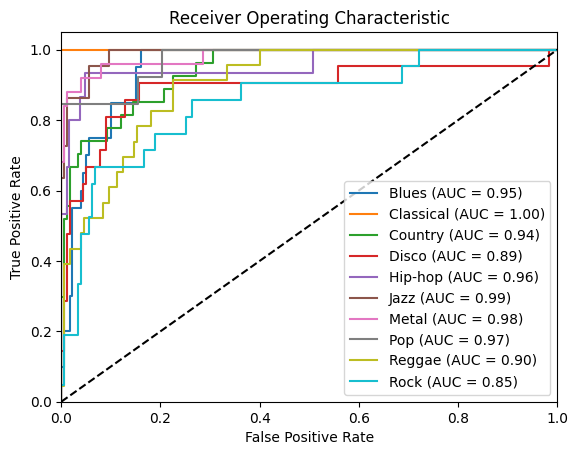

In [ ]:
#Plotting
probas = clf_30.predict_proba(X_test_30)
fpr = {}
tpr = {}
roc_auc = {}
print(clf_30.classes_.size)
for i in range(clf_30.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(y_test_30 == i, probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
genres = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
for i in range(clf_30.classes_.size):
    plt.plot(fpr[i], tpr[i], label='{0} (AUC = {1:0.2f})'.format(genres[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

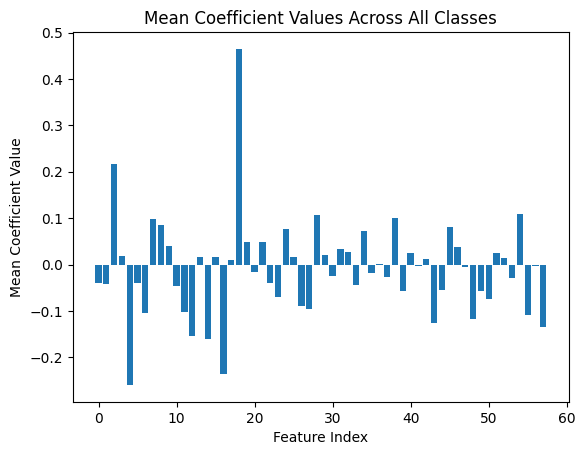

In [ ]:
#More plotting
# Train model and record coefficient values over time
coef = clf_30.coef_

# compute mean coefficient values across all classes
coef_mean = np.mean(coef, axis=0)

# plot mean coefficient values using a bar plot
plt.bar(range(len(coef_mean)), coef_mean)
plt.xlabel('Feature Index')
plt.ylabel('Mean Coefficient Value')
plt.title('Mean Coefficient Values Across All Classes')
plt.show()

In [ ]:
#K-fold cross validation to find the best C
c_values = np.logspace(-4, 4, 20) #logarithmically spaced C values between 10^-4 and 10^4

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []
for c in c_values:
    model = LogisticRegression(penalty='l2', C=c)
    cv_scores = cross_val_score(clf_30, X_train_30, y_train_30, cv=kfold, scoring='accuracy')
    scores.append(np.mean(cv_scores))
    


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

In [ ]:
best_index = np.argmax(scores)
best_c = c_values[best_index]
print(best_c)

0.0001


Classification Report on the Training Data of the Logistic Classification model of 30 seconds sounds
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        80
           1       0.95      0.99      0.97        87
           2       0.80      0.75      0.77        73
           3       0.78      0.80      0.79        79
           4       0.89      0.75      0.82        85
           5       0.89      0.91      0.90        78
           6       0.83      0.91      0.87        75
           7       0.88      0.93      0.91        87
           8       0.79      0.86      0.82        77
           9       0.76      0.66      0.71        79

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.83       800
weighted avg       0.84      0.84      0.84       800


Classification Report on the Test Data of the Logistic Classification model of 30 seconds sounds
              precision    recall  f1-scor

<Axes: >

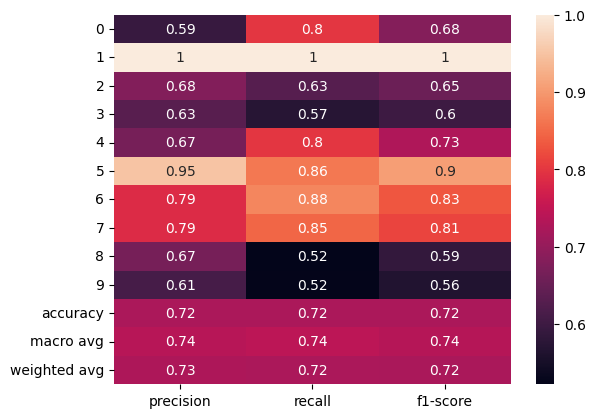

In [ ]:
#OUTPUT CELL OF 30 SECOND SOUNDS LOGISTIC REGRESSION

#print(confusion_matrix(y_train_30, predict_train_logistic))
print("Classification Report on the Training Data of the Logistic Classification model of 30 seconds sounds")
print(classification_report(y_train_30, predict_train_logistic_30))
print("=====================================================")
#print(confusion_matrix(y_test_30, predict_test_logistic))
print("\nClassification Report on the Test Data of the Logistic Classification model of 30 seconds sounds")
print(classification_report(y_test_30, predict_test_logistic_30))

import seaborn as sns

clf_report = classification_report(y_test_30, predict_test_logistic_30, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)


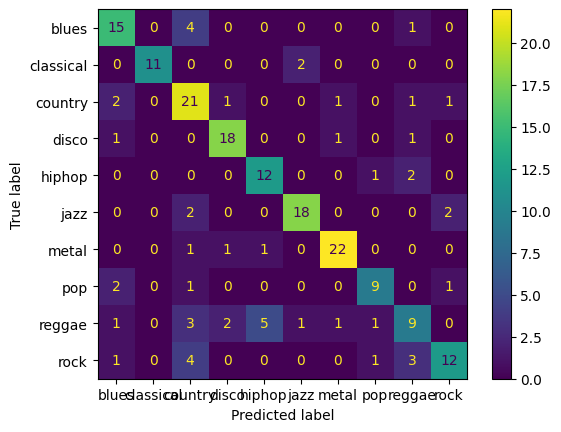


Classification Report on the Training Data of the Logistic Classification model of 30 seconds sounds with Degree  Poly Transformation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        87
           2       1.00      1.00      1.00        73
           3       1.00      1.00      1.00        79
           4       1.00      1.00      1.00        85
           5       1.00      1.00      1.00        78
           6       0.99      1.00      0.99        75
           7       1.00      1.00      1.00        87
           8       1.00      1.00      1.00        77
           9       1.00      0.99      0.99        79

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



Classification Report on the Test Data of the Logistic Classification model of 30 seconds sounds with De

<Axes: >

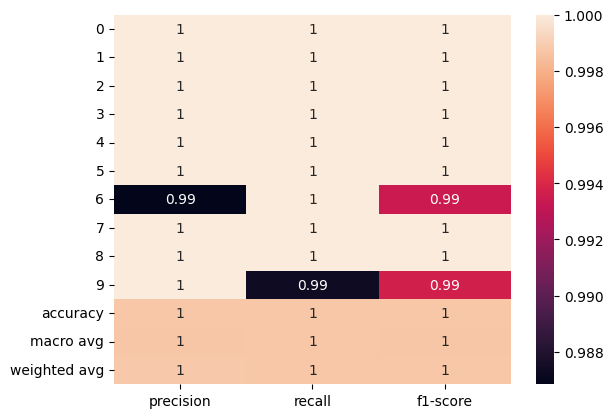

In [ ]:
#OUTPUT CELL OF 30 SECOND SOUNDS LOGISTIC REGRESSION WITH DEGREE 2 TRANSFORMATION
#print(confusion_matrix(y_train_30, predict_train_logistic_30_deg2))
titles_options = [("Confusion matrix 30 seconds", None),
                  ("Normalized confusion matrix", 'true')]

color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_30, predict_test_logistic_30_deg2), display_labels=label_index)
disp.plot()
plt.show()
print()
print("Classification Report on the Training Data of the Logistic Classification model of 30 seconds sounds with Degree  Poly Transformation")
print(classification_report(y_train_30, predict_train_logistic_30_deg2))
print("=====================================================")
#print(confusion_matrix(y_test_30, predict_test_logistic_30_deg2))
print()
print("\nClassification Report on the Test Data of the Logistic Classification model of 30 seconds sounds with Degree 2 Poly Transformation")
print(classification_report(y_test_30, predict_test_logistic_30_deg2))

clf_report = classification_report(y_train_30, predict_train_logistic_30_deg2, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)



In [ ]:
#OUTPUT CELL OF 3 SECOND SOUNDS LOGISTIC REGRESSION

#print(confusion_matrix(y_train_3, predict_train_logistic_3))
print("Classification Report on the Training Data of the Logistic Classification model of 3 seconds sounds")
print(classification_report(y_train_3, predict_train_logistic_3))
print("=====================================================")
#print(confusion_matrix(y_test_3, predict_test_logistic))
print("\nClassification Report on the Test Data of the Logistic Classification model of 3 seconds sounds")
print(classification_report(y_test_3, predict_test_logistic_3))

Classification Report on the Training Data of the Logistic Classification model of 3 seconds sounds
              precision    recall  f1-score   support

       blues       0.68      0.73      0.71       792
   classical       0.92      0.96      0.94       795
     country       0.64      0.63      0.64       811
       disco       0.66      0.69      0.67       800
      hiphop       0.72      0.64      0.68       780
        jazz       0.79      0.82      0.81       808
       metal       0.80      0.87      0.83       796
         pop       0.79      0.82      0.80       820
      reggae       0.65      0.64      0.65       789
        rock       0.59      0.47      0.52       801

    accuracy                           0.73      7992
   macro avg       0.72      0.73      0.72      7992
weighted avg       0.72      0.73      0.72      7992


Classification Report on the Test Data of the Logistic Classification model of 3 seconds sounds
              precision    recall  f1-score 

In [ ]:
# Define the path to the folder containing the Mel spectrograms

"""folder_path = '/content/drive/MyDrive/ML_genre_classification_nn_project/Data/images_original'

# Load the data from each file
X = []
y = []
for genre in ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']:
    for i in range(0, 10):
        if(i < 10):
          i = genre + "0000" + str(i)
        else:
          i = genre + "000" + str(i)
        img = Image.open(f"{folder_path}/{genre}/{i}.png")
        X.append(np.array(img))
        y.append(genre)

# Convert the genre labels to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

# Shuffle the data
X, y = shuffle(X, y)

# Convert data and labels to NumPy arrays
data = np.array(X)
labels = np.array(y)



# Normalize the input data
max_pixel_value = np.max(data)
data = data.astype('float32') / max_pixel_value
labels = to_categorical(labels)
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)




# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train_30[0].shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_30, y_train_30, epochs=10, batch_size=32, validation_data=(X_test_30, y_test_30))

# Evaluate the model on the test set
y_pred = np.argmax(model.predict(X_test_30), axis=-1)
print(classification_report(np.argmax(y_test_30, axis=-1), y_pred, target_names=le.classes_))
"""

'folder_path = \'/content/drive/MyDrive/ML_genre_classification_nn_project/Data/images_original\'\n\n# Load the data from each file\nX = []\ny = []\nfor genre in [\'blues\', \'classical\', \'country\', \'disco\', \'hiphop\', \'jazz\', \'metal\', \'pop\', \'reggae\', \'rock\']:\n    for i in range(0, 10):\n        if(i < 10):\n          i = genre + "0000" + str(i)\n        else:\n          i = genre + "000" + str(i)\n        img = Image.open(f"{folder_path}/{genre}/{i}.png")\n        X.append(np.array(img))\n        y.append(genre)\n\n# Convert the genre labels to numerical values\nle = LabelEncoder()\ny = le.fit_transform(y)\n\n# Shuffle the data\nX, y = shuffle(X, y)\n\n# Convert data and labels to NumPy arrays\ndata = np.array(X)\nlabels = np.array(y)\n\n\n\n# Normalize the input data\nmax_pixel_value = np.max(data)\ndata = data.astype(\'float32\') / max_pixel_value\nlabels = to_categorical(labels)\ntrain_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 


              precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       1.00      0.92      0.96        13
           2       0.78      0.67      0.72        27
           3       0.59      0.76      0.67        21
           4       0.58      0.73      0.65        15
           5       0.91      0.91      0.91        22
           6       0.85      0.92      0.88        25
           7       0.75      0.69      0.72        13
           8       0.57      0.35      0.43        23
           9       0.57      0.57      0.57        21

    accuracy                           0.73       200
   macro avg       0.73      0.74      0.73       200
weighted avg       0.73      0.73      0.72       200

Best C: 1000, Best gamma: -4.


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: ignored

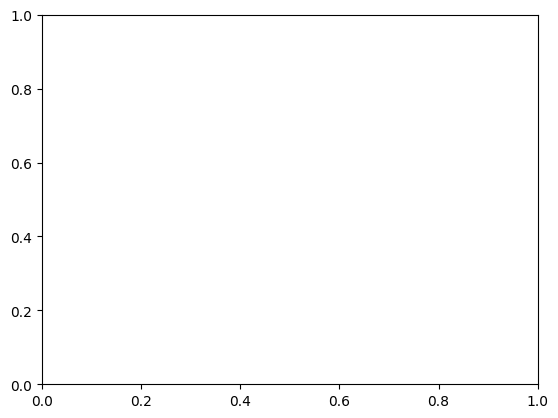

In [ ]:
#SVM Code

# Define the SVM model with a linear kernel and one-vs-all classification
svm = SVC(kernel='sigmoid', decision_function_shape='ovr')

# Define the parameter grid to search over
param_grid = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10,100,1000], 'coef0': [-40,-20,-5,-4,-3,-2,-1,0,1,2,3,4,5]}
# Run a grid search over the parameter grid using 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5)

# Fit the model to the training data
grid_search.fit(X_train_30, y_train_30)

# Get the best model from the grid search
best_svm = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_svm.predict(X_test_30)
print()
print(classification_report(y_test_30, y_pred))
# Calculate the accuracy of the model on the test data
#accuracy = accuracy_score(y_test_30, y_pred)
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['coef0']
print("Best C: {}, Best gamma: {}.".format(best_C,best_gamma))
#print('Accuracy:', accuracy)

#Plotting 

# Define the plot boundaries
# Create a meshgrid of points to plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = best_svm.predict(X_test_30)


# Plot the decision boundary and the data
plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.title("SVM with RBF Kernel (C=10, gamma=0.1)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()